<a href="https://colab.research.google.com/github/YujinChoi0410/IR_Ship_Recognition/blob/main/segment_final_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Keras CNN으로 이미지 분할하기


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. 패키지 수입

In [ ]:
# 1번 블락
import numpy as np
import os
# python image library (PIL)
from PIL import Image
from PIL.ImageOps import autocontrast
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img, array_to_img
from keras.models import Model
from keras.layers import Conv2D, SeparableConv2D
from keras.layers import BatchNormalization, Activation
from keras.layers import Input, MaxPooling2D, Add
from keras.layers import Conv2DTranspose, UpSampling2D


In [ ]:
# 2번 블락

# 하이퍼 파라미터
MY_EPOCH = 50
MY_BATCH = 32
MY_RES = 160

# 데이터 처리 모드
DATA_MODE = 0

# CNN 학습 모드
TRAIN_MODE = 1

# 데이터 경로
MY_PATH = '/content/drive/MyDrive/dataset/pet'

2. 데이터 처리

In [ ]:
# 3번 블락

# 입력 이미지 경로 처리
input_dir = os.path.join(MY_PATH, 'images')
print(input_dir)
img_path = sorted([
                   os.path.join(input_dir, fname)
                   for fname in os.listdir(input_dir)
])

img_tot = len(img_path)
print('입력 이미지 갯수:', len(img_path))
print('샘플 경로:', img_path[0])


/content/drive/MyDrive/dataset/pet/images
입력 이미지 갯수: 1190
샘플 경로: /content/drive/MyDrive/dataset/pet/images/Ragdoll_1.jpg


In [ ]:
# 4번 블락

# 출력 이미지 경로
target_dir = os.path.join(MY_PATH, 'trimaps')
target_path = sorted([
                      os.path.join(target_dir, fname)
                      for fname in os.listdir(target_dir)
])

print('출력 이미지 갯수:', len(target_path))
print('샘플 이미지 경로:', target_path[0])

출력 이미지 갯수: 1190
샘플 이미지 경로: /content/drive/MyDrive/dataset/pet/trimaps/Ragdoll_1.png


In [ ]:
# 5번 블락

# 출력 이미지 정보 출력
which = 28
img = load_img(target_path[which])
print(img)
img = autocontrast(img)

# PIL 이미지를 numpy 행렬로 전환
np.set_printoptions(threshold=np.inf)
tmp = np.unique(np.asarray(img))
print(tmp)

# trimaps 룰
# 1: 대상 -> 0 (검정)
# 2: 배경 -> 127 (회색)
# 3: 윤곽 -> 255 (흰색)

<PIL.Image.Image image mode=RGB size=291x500 at 0x7F42D2C29790>
[  0 127 255]


(-0.5, 290.5, 499.5, -0.5)

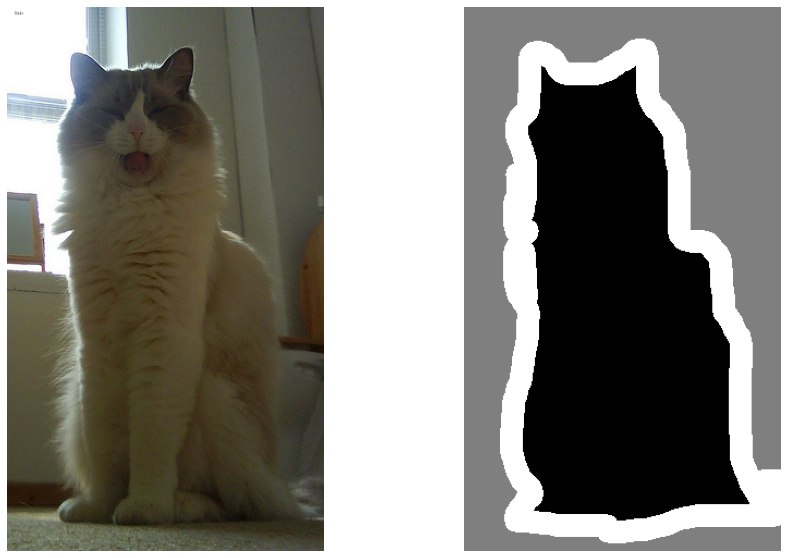

In [ ]:
# 6번 블락

# 샘플 이미지 출력
fig, spot = plt.subplots(1, 2, figsize=(15, 10))
spot[0].imshow(Image.open(img_path[which]))
spot[0].axis('off')

#spot[1].imshow(Image.open(target_path[which]))
spot[1].imshow(autocontrast(load_img(target_path[which])))
spot[1].axis('off')


In [ ]:
# 7번 블락

# 이미지 화소 스케일링
# 20분 소요
if DATA_MODE:
    print('데이터 스케일링 시작')
    begin = time()

    # 4차원 numpy data
    # 3은 RGB channel 수
    X_data = np.zeros((img_tot, MY_RES, MY_RES, 3))
    for j, path in enumerate(img_path):

        # 이미지 크기 통일 하기
        # channel은 그대로 3으로 유지
        #tmp = load_img(path)
        img = load_img(path, target_size=(MY_RES, MY_RES))
        X_data[j] = img

    end = time()
    print('입력 데이터 처리 시간: {:.2f}초'.format(end-begin))
    print('입력 데이터 모양:', X_data.shape)


In [ ]:
# 8번 블락

# 출력 이미지 (= 윤곽선 결과) 처리
if DATA_MODE:
    print('출력 이미지 처리 시작')
    begin = time()

    Y_data = np.zeros((img_tot, MY_RES, MY_RES, 1))
    for j, path in enumerate(target_path):
        map = load_img(path, target_size=(MY_RES, MY_RES), color_mode='grayscale')

        # 채널 정보 추가
        tmp = np.asarray(map)
        #print(tmp.shape)
        Y_data[j] = np.expand_dims(map, axis=2)
        #print(Y_data[j].shape)
        #print('전:', np.unique(Y_data[j]))

        # trimap 데이터 범위를 [1, 2, 3]에서 [0, 1, 2]로 전환
        Y_data[j] -= 1
        #print('후:', np.unique(Y_data[j]))
    end = time()
    print('출력 데이터 처리 시간: {:.2f}초'.format(end-begin))
    print('출력 데이터 모양:', Y_data.shape)


In [ ]:
# 9번 블락

# numpy 데이터 저장
if DATA_MODE:
    with open('arrays.npy', 'wb') as f:
        np.save(f, X_data)
        np.save(f, Y_data)

    print('numpy 데이터 파일 완성')

else:
    with open('/content/drive/MyDrive/dataset/arrays.npy', 'rb') as f:
        X_data = np.load(f, allow_pickle=True)
        Y_data = np.load(f, allow_pickle=True)


OSError: ignored

In [ ]:
# 10번 블락

# 160x160 scaling 후 이미지 출력
fig, spot = plt.subplots(1, 2, figsize=(15, 10))

# 컬러 이미지 출력
img = array_to_img(X_data[which])
spot[0].imshow(img)
spot[0].axis('off')

# 윤곽 데이터 출력
img = array_to_img(Y_data[which])
spot[1].imshow(img)
spot[1].axis('off')


In [ ]:
# 11번 블락

# 데이터 4분할
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2)

# 최종 데이터 모양 확인
print('학습용 입력 데이터 모양:', X_train.shape)
print('학습용 출력 데이터 모양:', Y_train.shape)
print('평가용 입력 데이터 모양:', X_test.shape)
print('평가용 출력 데이터 모양:', Y_test.shape)


3. 인공 신경망 구현

In [ ]:
# 12번 블락

# Unet의 전반부 인코더 구현
def build_enc():
    # 입력층 구현
    inputs = Input(shape=(MY_RES, MY_RES, 3))

    # 합성곱 블락 0
    x = Conv2D(filters=32,
               kernel_size=3,
               strides=2,
               padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 잔차 연결 준비
    jump = x

    # 합성곱 블락 1, 2, 3 구현
    for filters in [64, 128, 256]:
        # 첫번째 합성곱
        x = Activation('relu')(x)
        x = SeparableConv2D(filters,
                            kernel_size=3,
                            padding='same')(x)
        x = BatchNormalization()(x)

        # 두번째 합성곱
        x = Activation('relu')(x)
        x = SeparableConv2D(filters,
                            kernel_size=3,
                            padding='same')(x)
        x = BatchNormalization()(x)

        # 풀링
        x = MaxPooling2D(pool_size=3,
                         strides=2,
                         padding='same')(x)

        # 잔차 연결
        residual = Conv2D(filters,
                          kernel_size=1,
                          strides=2,
                          padding='same')(jump)
        
        # 두 갈래 묶어주기
        x = Add()([x, residual])
        jump = x

    # 입력과 출력값 return
    return inputs, x



In [ ]:
# 13번 블락
def build_dec(inputs, x):
    # 잔차 연결 준비
    jump = x

    # 합성곱 블락 4번 반복
    for filters in [256, 128, 64, 32]:
        # 첫번째 합성곱
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters,
                            kernel_size=3,
                            padding='same')(x)
        x = BatchNormalization()(x)

        # 두번째 합성곱
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters,
                            kernel_size=3,
                            padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D(size=2)(x)

        # 잔차 블럭
        residual = UpSampling2D(size=2)(jump)
        residual = Conv2D(filters,
                          kernel_size=1,
                          padding='same')(residual)

        # 더하기
        x = Add()([x, residual])
        jump = x

    # 최종 출력층
    outputs = Conv2D(filters=3,
                     kernel_size=3,
                     activation='softmax',
                     padding='same')(x)

    # Unet 출력
    model = Model(inputs, outputs)
    
    return model


In [ ]:
# 14번 블락

inputs, link = build_enc()
model = build_dec(inputs, link)

print('Unet 요약')
model.summary()

4. 인공신경망 학습

In [ ]:
# 15번 블락
# Unet 학습 시작
if TRAIN_MODE:
    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy')
    
    print('학습 시작')
    begin = time()
    model.fit(X_train, Y_train, MY_BATCH, MY_EPOCH, verbose=1)
    end = time()

    print('총 학습 시간:{:.2f}'.format(end - begin))
    model.save_weights('segment.h5')
else:
    model.load_weights('/content/drive/MyDrive/dataset/segment.h5')


5. 인공 신경망 활용

In [ ]:
# 16번 블락
fig, spot = plt.subplots(1, 3, figsize=(15, 8))

# 컬러 이미지 출력
img = array_to_img(X_test[which])
spot[0].imshow(img)
spot[0].axis('off')

# 정답 출력
img = array_to_img(Y_test[which])
spot[1].imshow(img)
spot[1].axis('off')

# 기계 추측 
pred = model.predict(X_test, verbose=1)
mask = np.argmax(pred[which], axis=2) #출력결과 2차원 배열 (160, 160)
mask = np.expand_dims(mask, axis=2) #3차원으로 늘려주기(160, 160, 1) 그래야 출력가능

img = array_to_img(mask)
spot[2].imshow(img)
spot[2].axis('off')
